# ***** Libraries ***** 

In [34]:
import pandas as pd

from astropy.table import Table
from astropy.io import fits

import matplotlib.pyplot as plt 
import numpy as np
from scipy.integrate import quad


import time

# ***** References ***** 

* (Amati, 2002) -- Amati, L., “Intrinsic spectra and energetics of BeppoSAX Gamma-Ray Bursts with known redshifts”, Astronomy and Astrophysics, vol. 390, pp. 81–89, 2002. doi:10.1051/0004-6361:20020722.

* (Bloom, 2001) -- Bloom, J. S., Frail, D. A., and Sari, R., “The Prompt Energy Release of Gamma-Ray Bursts using a Cosmological k-Correction”, The Astronomical Journal, vol. 121, no. 6, pp. 2879–2888, 2001. doi:10.1086/321093.

* FERMIGBRST - Fermi GBM Burst Catalog https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html

* (Yonetoku, 2004) -- Yonetoku, D., Murakami, T., Nakamura, T., Yamazaki, R., Inoue, A. K., and Ioka, K., “Gamma-Ray Burst Formation Rate Inferred from the Spectral Peak Energy-Peak Luminosity Relation”, The Astrophysical Journal, vol. 609, no. 2, pp. 935–951, 2004. doi:10.1086/421285.

* (Zhang, 2018) -- Zhang, B. (2018). The Physics of Gamma-Ray Bursts. Cambridge: Cambridge University Press. doi:10.1017/9781139226530

# ***** Functions *****

#### Constants:

In [25]:
# Cosmology constants
# from Planck 2015
H0 = 67.8; # km/s/Mpc
omegaM, omegaK, omegaL = 0.308, 0, 0.692
c = 2.998e10
pi=np.pi
kevToErg = 1.602e-9
mpcToCm = 3.086e24
kmToCm = 1e5

In [26]:
lower_limit_bol = 1 #keV
upper_limit_bol = 1e4 #keV

lower_limit_inst = 8 #keV
upper_limit_inst = 1e3 #keV 

redshift = np.arange(0.001,10.,0.01) #ideally step shoud be 0.0001

In [4]:
#class models:
#def get_k_corr_band(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower_bol, upper_bol, lower_inst, upper_inst):
#    """
#    Returns k-correction using BAND model.  
#    
#    Formulae from (Zhang, 2018), p.97
#    Model eqution from (Yonetoku, 2004)
#    
#    alpha, beta            -- The power law index of a function fit to a single spectrum over the duration of the burst, 
#    ePeak                  -- observed peak energy of some model fit to a single spectrum
#                              over the duration of the burst, in Fermi GBM catalogue [keV], 
#    ePiv                   -- The pivot energy of a Comptonized model fit to a single spectrum over the 
#                              duration of the burst, [keV]. This parameter is typically fixed, 
#    normalization          -- amplitude of a function fit to a single spectrum over the 
#                              duration of the burst, [photon/cm2/s/keV], 
#    duration               -- =(spectrum_start-spectrum_stop), 
#    redshift               -- redshift of object, 
#    lower_bol, upper_bol   -- limits of ebergy band, bolometric, =(1-1e4 keV)
#    lower_inst, upper_inst -- energy band of instrument [keV]
#    
#    
#    """
#    
#    Flux_bol = _bandFlux(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower_bol, upper_bol)
#    Flux_inst = _bandFlux(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower_inst, upper_inst)
#    
#    return Flux_bol/Flux_inst


def get_E_peak_rest_frame(E_peak_obs,redshift):
    """
    Returns peak energy in rest frame (very near ("on") object) 
    in the same units as E_peak_obs
    (Zhang, 2018, p. 102)
    
    epeak    -- observed peak energy of some model fit 
                to a single spectrum over the duration of the burst, in Fermi GBM catalogue
                is given in keV
    redshift -- redshift of object
    """
    
    return float(E_peak_obs)*(1+float(redshift))
        
def luminosity_distance(redshift):
    """
    Returns luminosity distance
    !!! Y.'s code
    """
    dH = c*mpcToCm/kmToCm/H0 #constants
    function = lambda x: (1/np.sqrt(omegaM*(1+x)**3+omegaK*(1+x)**2+omegaL))
    lower, upper = 0, redshift
    return dH  * quad(function,lower,upper)[0] * (1 + redshift)

def luminosity_area(redshift):
    """
    Returns luminosity area
    !!! Y.'s code
    """    
    luminosityDistance = models.luminosity_distance(redshift)
    luminosityArea = 4 * pi * luminosityDistance**2
    return luminosityArea

def get_L_iso_bol_peak(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower_bol, upper_bol, lower_inst, upper_inst):
    """
    Returns isotropic bolometric peak luminosity 
    dist_lum -- 
    peak_flux --
    k_c --
    """
    lum_dist = luminosity_distance(redshift)
    peak_flux = _bandFlux(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower_inst, upper_inst) #??????? inst or not
    #k_corr = get_k_corr_band(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower_bol, upper_bol, lower_inst, upper_inst)
    
    return 4 * 3.141592653589793 * lum_dist**2 * peak_flux #* k_corr

def _bandFlux(alpha, beta, ePeak, ePiv, normalization, duration, redshift, lower, upper):
    """
    model parameters are from the fitting result in observer's frame.
    integration from lower/(1+z) to upper/(1+z) in the observer's frame,
    which are the corrsponding energy from lower to upper in the rest frame. 
    set redshift = 0 in order to compute the flux in observer's frame.
    """
    
# if no data or bad data, return 0.
    if normalization <= 0: return 0
    if (ePeak <= 0 ): return 0 
    if (upper == ""): return 0 

    middle = (alpha-beta)*ePeak/(2+alpha) #neccessary to find summ of two equations
    
    # if alpha < beta, middle will be negtive. 
    if (middle < lower): middle = lower
    if (upper < middle): middle = upper 

    lower, middle, upper = lower/(1+redshift), middle/(1+redshift), upper/(1+redshift)

    functionLow = lambda x: normalization*x*(x/ePiv)**alpha*np.exp(-x*(2+alpha)/ePeak)
    functionHigh = lambda x: normalization*x*((alpha-beta)*ePeak/(2+alpha)/ePiv)**(alpha-beta)*np.exp(beta-alpha)*(x/ePiv)**beta
    
    resultLow = quad( functionLow, lower, middle )[0]
    resultHigh = quad( functionHigh, middle, upper)[0]

    flux = resultLow + resultHigh
    return flux


def luminosity_power_low_ez_yonetoku_2004(E_peak_z, redshift):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    Based on (Amati, 2002) and (Yonetoku, 2004) data
    """
    luminosity = 2.34 * 1e-5 * (E_peak_z / 1e3)**2 * 1e52
    luminosity_upper = (2.34+2.29) * 1e-5 * (E_peak_z/ 1e3)**(2-0.2) * 1e52
    luminosity_lower = (2.34-1.76) * 1e-5 * (E_peak_z/ 1e3)**(2+0.2) * 1e52
    
    return luminosity, luminosity_upper, luminosity_lower

def luminosity_power_low_eobs_yonetoku_2004(E_peak_obs, redshift):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    Based on (Amati, 2002) and (Yonetoku, 2004) data
    """
    luminosity = 2.34 * 1e-5 * (E_peak_obs * (1 + redshift) / 1e3)**2 * 1e52
    luminosity_upper = (2.34+2.29) * 1e-5 * (E_peak_obs * (1 + redshift) / 1e3)**(2-0.2) * 1e52
    luminosity_lower = (2.34-1.76) * 1e-5 * (E_peak_obs * (1 + redshift) / 1e3)**(2+0.2) * 1e52
    
    return luminosity, luminosity_upper, luminosity_lower

# ***** Data *****

## - - - - - - - - - - - - - 
## (Yonetoku, 2004)

### --- Figure 1 and Table 1 ---

In [5]:
yonetoku_data_st = pd.read_csv("2004_yonetoku_grb_table_2.csv")

In [6]:
yonetoku_data_st.columns

Index(['grb', 'redshift', 'ra', 'dec', 'Ep(1+z), (keV)',
       'peak flux, (10-6ergs cm-2s-1)', 'Peak Luminosity,  1052ergs s-1',
       'hi2/dof', 'k_c'],
      dtype='object')

Text(0, 0.5, '$Luminosity~[\\times 10^{52} erg/s]$')

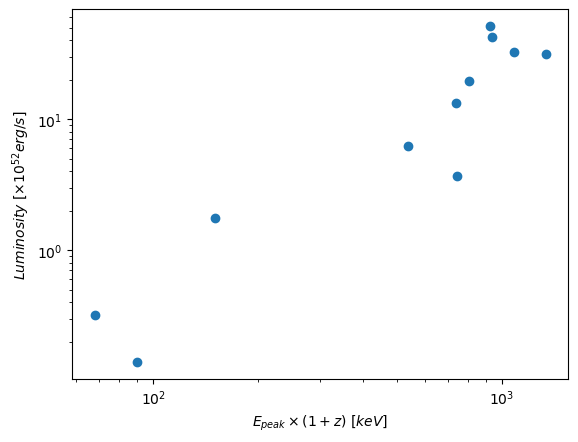

In [8]:
plt.scatter(yonetoku_data_st["Ep(1+z), (keV)"],yonetoku_data_st["Peak Luminosity,  1052ergs s-1"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_{peak} \times (1 + z)~[keV]$")
plt.ylabel(r"$Luminosity~[\times 10^{52} erg/s]$")

In [9]:
lum_model,lum_model_up,lum_model_low = luminosity_power_low_ez_yonetoku_2004(yonetoku_data_st["Ep(1+z), (keV)"]*1e3,redshift)

In [10]:
energy = np.log10(yonetoku_data_st["Ep(1+z), (keV)"])
luminosity = np.log10(yonetoku_data_st["Peak Luminosity,  1052ergs s-1"])
xp = np.arange(luminosity.min(),luminosity.max())
z = np.polyfit(energy,luminosity, 1)
polynomial = np.poly1d(z)
y_polynomial = polynomial(xp)

Text(0.5, 0, '$Luminosity~[\\times 10^{52} erg/s]$')

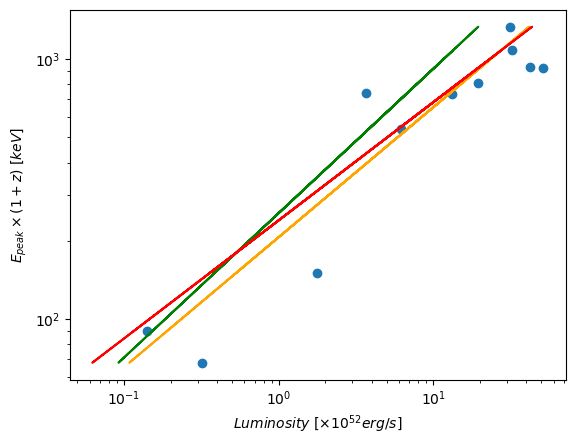

In [11]:
plt.plot(lum_model/1e52, yonetoku_data_st["Ep(1+z), (keV)"], color="orange", label=f"Полином ({1}), mid")
plt.plot(lum_model_up/1e52, yonetoku_data_st["Ep(1+z), (keV)"], color="green", label=f"Полином ({1}), up")
plt.plot(lum_model_low/1e52, yonetoku_data_st["Ep(1+z), (keV)"], color="red", label=f"Полином ({1}), low")
plt.scatter(yonetoku_data_st["Peak Luminosity,  1052ergs s-1"],yonetoku_data_st["Ep(1+z), (keV)"])
plt.xscale("log")
plt.yscale("log")

plt.ylabel(r"$E_{peak} \times (1 + z)~[keV]$")
plt.xlabel(r"$Luminosity~[\times 10^{52} erg/s]$")

### --- Table 2 ---

In [ ]:
yonetoku_data = pd.read_csv("2004_yonetoku_grb_energy_luminosity.csv")

In [ ]:
yonetoku_data

In [ ]:
E_peak_z = get_E_peak_rest_frame(yonetoku_data["Ep"],yonetoku_data["z"])

In [ ]:
for ind,l in enumerate(yonetoku_data["Lum"]):
    yonetoku_data["Lum"][ind]=float(l)

In [ ]:
plt.scatter(E_peak_z/1e3,yonetoku_data["Lum"]/1e52)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_{peak} \times (1 + z)~[keV]$")
plt.ylabel(r"$Luminosity~[\times 10^{52}~erg/s]$")

## - - - - - - - - - - - - - 

## Fermi

(FERMIGBRST)

* 	trigger_time <= 2022-12-31 23:59:59.999 UTC
*  	t90 (s) <= 2

As result of sampling we have 561 object

NOTES

* do smthg with decoding because it awful to have 
    
        b'somestring' 
    
    in table values

In [12]:
table = Table.read("fermi_results_short_2022.fits")
fermi_data = table.to_pandas()

In [13]:
fermi_data["E_peak"] = np.nan * len(fermi_data)          # E_peak
fermi_data["E_piv"] = np.nan * len(fermi_data)           # E_piv
fermi_data["Alpha"] = np.nan * len(fermi_data)           # alpha
fermi_data["Norm_amplitude"] = np.nan * len(fermi_data)  # normalization, A, amplitude
fermi_data["Duration"] = np.nan * len(fermi_data)        # delta T

### $E_{peak}$


Create a column with E_peak for COMP and BAND models,but only with values, because we don't need know which model it is. 

Then we drop rows with "unknown" peaks - actually these rows are ones of other best fitting models. 

In [14]:
for ind,model in enumerate(fermi_data['PFLX_BEST_FITTING_MODEL']):
    if model.lower().strip().decode(encoding='utf8') == "pflx_comp":
        fermi_data["E_peak"][ind] = fermi_data['PFLX_COMP_EPEAK'][ind]  #[keV]
        fermi_data["Alpha"][ind] = -1 * fermi_data['PFLX_COMP_INDEX'][ind] 
        fermi_data["Norm_amplitude"][ind] = fermi_data['PFLX_COMP_AMPL'][ind]
        fermi_data["Duration"][ind] = fermi_data['PFLX_SPECTRUM_STOP'][ind]-fermi_data['PFLX_SPECTRUM_START'][ind]
        fermi_data["E_piv"][ind] = fermi_data['PFLX_COMP_PIVOT'][ind]
        
    elif model.lower().strip().decode(encoding='utf8') =="pflx_band":
        fermi_data["E_peak"][ind] = fermi_data['PFLX_BAND_EPEAK'][ind]   #[keV]
        fermi_data["Alpha"][ind] = fermi_data['PFLX_BAND_ALPHA'][ind]
        fermi_data["Norm_amplitude"][ind] = fermi_data['PFLX_BAND_AMPL'][ind]
        fermi_data["Duration"][ind] = fermi_data['PFLX_SPECTRUM_STOP'][ind]-fermi_data['PFLX_SPECTRUM_START'][ind]
        fermi_data["E_piv"][ind] = 100 #keV, standart/constant value
        
        
fermi_data_band_comp = fermi_data[fermi_data["E_peak"].notna()].reset_index().drop("index",axis=1)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_34509/1169891733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data["E_peak"][ind] = fermi_data['PFLX_COMP_EPEAK'][ind]  #[keV]
/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_34509/1169891733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data["Alpha"][ind] = -1 * fermi_data['PFLX_COMP_INDEX'][ind]
/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_34509/1169891733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [22]:
e_peak_obs    = fermi_data_band_comp["E_peak"]
e_pivot       = fermi_data_band_comp["E_piv"]
alpha         = fermi_data_band_comp["Alpha"]
beta          = fermi_data_band_comp['PFLX_BAND_BETA']
normalization = fermi_data_band_comp["Norm_amplitude"]
duration      = fermi_data_band_comp["Duration"]

best_fit_mod  = fermi_data_band_comp['PFLX_BEST_FITTING_MODEL']
spec_start    = fermi_data_band_comp['PFLX_SPECTRUM_START']
spec_stop     = fermi_data_band_comp['PFLX_SPECTRUM_STOP']


comp_ampl     = fermi_data_band_comp['PFLX_COMP_AMPL']
comp_epeak    = fermi_data_band_comp['PFLX_COMP_EPEAK']
comp_pivot    = fermi_data_band_comp['PFLX_COMP_PIVOT']


band_alpha    = fermi_data_band_comp['PFLX_BAND_ALPHA']
band_ampl     = fermi_data_band_comp['PFLX_BAND_AMPL']
band_epeak    = fermi_data_band_comp['PFLX_BAND_EPEAK']
band_pivot    = 100 #keV, standart/constant value

### $E_{peak,z}$

In [28]:
fermi_data_band_comp["E_peak,z"] = None 

for ind in range(0,len(fermi_data_band_comp)):
    e_peak_z = []
    for z in redshift:
        e_peak_z.append(get_E_peak_rest_frame(e_peak_obs[ind], z))
    fermi_data_band_comp.at[ind,"E_peak,z"] = e_peak_z
    
len(fermi_data_band_comp["E_peak,z"][0])

1000

### $L_{peak,z}$

In [29]:
# get the start time
st = time.time()

fermi_data_band_comp["L_peak,z"] = None
for ind in range(len(fermi_data_band_comp)):
    luminosities_list = []
    for z in redshift:
        luminosities_list.append(get_L_iso_bol_peak(alpha[ind], b4eta[ind], e_peak_obs[ind], e_pivot[ind], normalization[ind], duration[ind], z, lower_limit_bol, upper_limit_bol, lower_limit_inst, upper_limit_inst))
    fermi_data_band_comp.at[ind,"L_peak,z"] = luminosities_list
    
# get the end time
et = time.time()

print('Execution time:', et-st, 'seconds')
len(fermi_data_band_comp["E_peak,z"][0])

Execution time: 39.724238872528076 seconds


1000

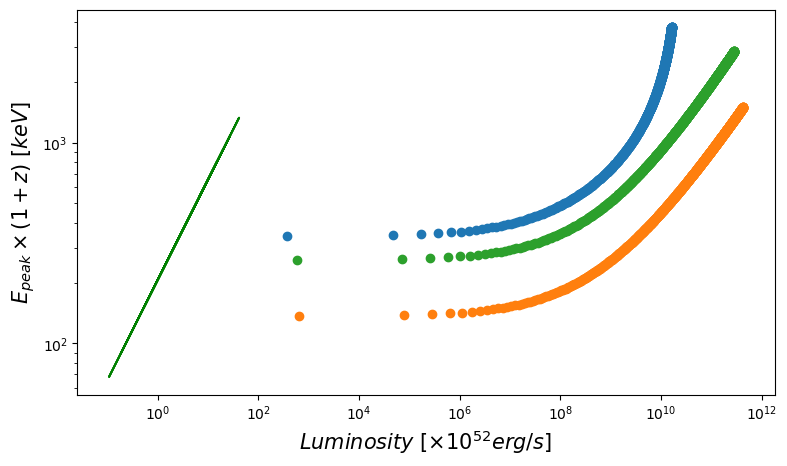

In [30]:

plt.figure(figsize=(9,5),dpi=100)
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$E_{peak} \times (1 + z)~[keV]$",fontsize=15)
plt.xlabel(r"$Luminosity~[\times 10^{52} erg/s]$", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.plot(lum_model/1e52,yonetoku_data_st["Ep(1+z), (keV)"], color="green", label=f"Полином ({1}), mid")
#plt.plot(lum_model_up/1e52,yonetoku_data_st["Ep(1+z), (keV)"], "--", lw=0.5, color="blue", label=f"Полином ({1}), mid")
#plt.plot(lum_model_low/1e52,yonetoku_data_st["Ep(1+z), (keV)"], "--", lw=0.5,color="red", label=f"Полином ({1}), mid")

#plt.plot()
#for grb_ind in range(len(fermi_data_band_comp)):
grb_ind=0
plt.scatter(np.array(fermi_data_band_comp["L_peak,z"][grb_ind])/1e52,fermi_data_band_comp["E_peak,z"][grb_ind])
plt.scatter(np.array(fermi_data_band_comp["L_peak,z"][100])/1e52,fermi_data_band_comp["E_peak,z"][100])
plt.scatter(np.array(fermi_data_band_comp["L_peak,z"][50])/1e52,fermi_data_band_comp["E_peak,z"][50])
    #plt.legend()
    #plt.ylim(0,1e52)


plt.figure(figsize=(15,10),dpi=150)
plt.plot(yonetoku_data_st["Ep(1+z), (keV)"], lum_model/1e52, color="green", label=f"Полином ({1}), mid")
plt.plot(yonetoku_data_st["Ep(1+z), (keV)"], lum_model_up/1e52, color="blue", label=f"Полином ({1}), mid")
plt.plot(yonetoku_data_st["Ep(1+z), (keV)"], lum_model_low/1e52, color="red", label=f"Полином ({1}), mid")
plt.xscale("log")
plt.yscale("log")
#plt.plot()
#for grb_ind in range(len(fermi_data_band_comp)):
grb_ind=0
plt.scatter(fermi_data_band_comp["E_peak,z"][0],np.array(fermi_data_band_comp["L_peak,z"][0])/1e52,)
plt.scatter(fermi_data_band_comp["E_peak,z"][100],np.array(fermi_data_band_comp["L_peak,z"][100])/1e52)
plt.scatter(fermi_data_band_comp["E_peak,z"][200],np.array(fermi_data_band_comp["L_peak,z"][200])/1e52)
    #plt.legend()
    #plt.ylim(0,1e52)